### Hobden and Nagrocki's Homework Assignment 4, Problem 2 Solution. 

This is a more efficient code-base for grabbing the data from the Crime Reports webpage. 

In [2]:
from datetime import date, datetime
from urllib.request import urlopen
from json import loads

def datestring_to_date(datestring):
    """
    Converts a string in the Crime Reports format to a real datetime.
    """
    from datetime import datetime
    return datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%SZ")

def get_crime_reports(start=date(2015,1,1), end=date(2016,3,1), incident_types=range(0,200)):
    """
    Gets a set of crime reports for the VicPD in roughly the Victoria area from roughly the start to end dates. This will take a bit due to rate limiting and the volume of data produced.

    Returns a list of CrimeReports.
    """
    # This covers most of Victoria
    rows = range(2831, 2834)
    cols = range(1286, 1291)
    
    start_param = start.strftime("%Y/%m/%d")
    end_param = end.strftime("%Y/%m/%d")

    crimes = []
    incident_types = ",".join([str(x) for x in incident_types])
    
    for row in rows:
        for col in cols:
            #print("Getting row "+str(row)+" col "+str(col))
            url = "https://www.crimereports.com/v3/crime_reports/map/search_by_tile.json?start_date="+start_param+"&end_date="+end_param+"&incident_type_ids="+incident_types+"&org_ids=1550&row="+str(row)+"&column="+str(col)+"&zoom=13&include_sex_offenders=false"
            raw_data = urlopen(url).read().decode("utf-8")
            this_data = loads(raw_data)
            if this_data["crimes"]:
                #print(str(len(this_data["crimes"]))+" crimes found on this tile")
                for item in this_data["crimes"]:
                    crimes.append(item)
                    
    # It was discovered that the data is frequently duplicated. Let's dedup.
    seen_ids = set()
    unique_crimes = []
    for crime in crimes:
        if crime["id"] not in seen_ids:
            seen_ids.add(crime["id"])
            unique_crimes.append(crime)

    return unique_crimes

Now lets get the crimes arranged by category, first we need to build out the categories. Initial data retrieved by running the following JS in page console. Figured out by inspecting the minified source.

In [3]:
categories = {};
categoryTypes.map(function (x) {
    created_cat = {};
    created_cat.id = x.id;
    if (x.children) {
        created_cat.children = {};
        x.children.map(function (y) {
            created_subcat = {};
            created_subcat.id = y.id;
            created_cat.children[y.name] = created_subcat;
        });
    }
    categories[x.name] = created_cat;
});
JSON.stringify(categories, null, 2)

SyntaxError: invalid syntax (<ipython-input-3-3ad723eb2dc8>, line 2)

In [4]:
categories = {
  "Homicide": {
    "id": 104,
    "children": {}
  },
  "Breaking & Entering": {
    "id": 100,
    "children": {}
  },
  "Robbery": {
    "id": 98,
    "children": {}
  },
  "Theft": {
    "id": 103,
    "children": {}
  },
  "Theft of Vehicle": {
    "id": 99,
    "children": {}
  },
  "Theft from Vehicle": {
    "id": 101,
    "children": {}
  },
  "Vehicle Recovery": {
    "id": 170,
    "children": {}
  },
  "Sexual Offense": {
    "id": 8,
    "children": {
      "Other Sexual Offense": {
        "id": 97
      },
      "Sexual Assault": {
        "id": 148
      }
    }
  },
  "Assault ": {
    "id": 9,
    "children": {
      "Assault": {
        "id": 149
      },
      "Assault with Deadly Weapon": {
        "id": 150
      }
    }
  },
  "Property Crime ": {
    "id": 10,
    "children": {
      "Property Crime": {
        "id": 180
      },
      "Property Crime Commercial": {
        "id": 179
      },
      "Property Crime Residential": {
        "id": 178
      }
    }
  },
  "Other ": {
    "id": 11,
    "children": {
      "Alarm": {
        "id": 160
      },
      "Arson": {
        "id": 121
      },
      "Death": {
        "id": 162
      },
      "Family Offense": {
        "id": 164
      },
      "Kidnapping": {
        "id": 165
      },
      "Missing Person": {
        "id": 167
      },
      "Other": {
        "id": 151
      },
      "Weapons Offense": {
        "id": 171
      }
    }
  },
  "Quality of Life": {
    "id": 12,
    "children": {
      "Disorder": {
        "id": 163
      },
      "Drugs": {
        "id": 168
      },
      "Liquor": {
        "id": 166
      }
    }
  },
  "Traffic": {
    "id": 169,
    "children": {}
  },
  "Fire": {
    "id": 15,
    "children": {}
  },
  "Emergency": {
    "id": 16,
    "children": {}
  },
  "Proactive Policing": {
    "id": 14,
    "children": {
      "Community Policing": {
        "id": 161
      },
      "Pedestrian Stop": {
        "id": 173
      },
      "Vehicle Stop": {
        "id": 172
      }
    }
  }
}

# Build a lookup dict 
category_id_lookup = {}
for category_name,category in categories.items():
    category_id_lookup[category["id"]] = category
    if category["children"]:
        for child_name,child in category["children"].items():
            category_id_lookup[child["id"]] = child
for category in category_id_lookup.keys():
    category_id_lookup[category]["crimes"] = []
    

In [5]:
# Get all the reports. This takes a few seconds and is thus it's on cell. Avoid re-running this.
crimes = get_crime_reports(incident_types=category_id_lookup.keys())

Arrange the crimes into their appropriate places.

In [6]:
for crime in crimes:
    category = category_id_lookup[crime['incident_type_id']]
    category["crimes"].append(crime)

## Frequency Breakdowns

In [7]:
for category,data in categories.items():
    print("{:5d} {:30s}".format(len(data["crimes"]), category))
    for child_name,child_data in data["children"].items():
        print("\t {:5d} {:30s}".format(len(child_data["crimes"]), child_name))

    0 Quality of Life               
	   196 Drugs                         
	   142 Disorder                      
	   633 Liquor                        
 1187 Theft                         
    0 Proactive Policing            
	   386 Pedestrian Stop               
	     1 Community Policing            
	   225 Vehicle Stop                  
    0 Other                         
	     0 Missing Person                
	     0 Kidnapping                    
	    51 Weapons Offense               
	    16 Arson                         
	    81 Alarm                         
	  1457 Other                         
	     0 Family Offense                
	     0 Death                         
    0 Emergency                     
    0 Vehicle Recovery              
    0 Homicide                      
   43 Robbery                       
  104 Theft of Vehicle              
    0 Sexual Offense                
	     0 Sexual Assault                
	     0 Other Sexual Offense          
    0 

It was noted that the "parents" are not necessarily composed of their children. This is probably due to legacy data.

In [8]:
%pylab inline

def heatmap(crimes, excluder):
    import folium
    from folium import plugins
    data = []
    for crime in crimes:
        if excluder(crime):
            data.append([crime["lat"], crime["lng"], 0.1])
    mapa = folium.Map([48.4323, -123.3720], tiles='OpenStreetMap', zoom_start=13)
    mapa.add_children(plugins.HeatMap(data))
    return mapa

def bars(title, crimes, variant):
    import numpy
    import matplotlib.pyplot as plot

    if variant == "weekday":
        days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        ind = numpy.arange(len(days))    # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence

        morning = [0]*7; afternoon = [0]*7; night = [0]*7;
        for crime in crimes:
            hour_of_crime = datestring_to_date(crime["incident_date_time"]).time().hour
            day_of_week = datestring_to_date(crime["incident_date_time"]).weekday()
            if (hour_of_crime > 2 and hour_of_crime < 12):
                morning[day_of_week] += 1
            elif (hour_of_crime > 12 and hour_of_crime < 20):
                afternoon[day_of_week] += 1
            else:
                night[day_of_week] += 1

        morning_bar = plot.bar(ind, morning, width, color="r", label="Morning")
        afternoon_bar = plot.bar(ind, afternoon, width, color="g", label="Afternoon", bottom=morning)
        night_bar = plot.bar(ind, night, width, color="b", label="Night", bottom=[x+y for x,y in zip(morning,afternoon)])

        plot.ylabel('Instances')
        plot.title(str(title) + ' by Weekday')
        plot.xticks(ind + width/2., ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    elif variant == "monthday":
        days = [0]*31
        ind = numpy.arange(len(days))    # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence

        for crime in crimes:
            day = datestring_to_date(crime["incident_date_time"]).day # 1 index.
            days[day-1] += 1

        for day,instances in enumerate(days):
            plot.bar(day, instances, width, label=(day+1))

        plot.ylabel('Instances')
        plot.title(str(title) + ' by Day of Month')
    elif variant == "month":
        months = [0]*12
        ind = numpy.arange(len(months))    # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence

        for crime in crimes:
            month = datestring_to_date(crime["incident_date_time"]).month # 1 index.
            months[month-1] += 1

        for month,instances in enumerate(months):
            plot.bar(month, instances, width, label=datestring_to_date(crime["incident_date_time"]).strftime("%B"))

        plot.ylabel('Instances')
        plot.title(str(title) + ' by Month')
    elif variant == "date":
        months = [0]*12
        ind = numpy.arange(len(months))    # the x locations for the groups
        width = 0.35       # the width of the bars: can also be len(x) sequence

        for crime in crimes:
            month = datestring_to_date(crime["incident_date_time"]).month # 1 index.
            months[month-1] += 1

        for month,instances in enumerate(months):
            plot.bar(month, instances, width, label=datestring_to_date(crime["incident_date_time"]).strftime("%B"))

        plot.ylabel('Instances')
        plot.title(str(title) + ' by Month')
    else:
        return "BADDD"
    
    plot.show()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
heatmap(categories["Quality of Life"]["children"]["Drugs"]["crimes"],
        lambda x: datestring_to_date(x["incident_date_time"]).weekday() == 4)

### Theft Morning/Afternoon/Night
First, day between 2AM and 12PM:

In [10]:
heatmap(categories["Theft"]["crimes"],
        lambda x: datestring_to_date(x["incident_date_time"]).time().hour > 2 and
                  datestring_to_date(x["incident_date_time"]).time().hour < 12)

In [11]:
heatmap(categories["Theft"]["crimes"],
        lambda x: datestring_to_date(x["incident_date_time"]).time().hour > 12 and
                  datestring_to_date(x["incident_date_time"]).time().hour < 20)

In [12]:
heatmap(categories["Theft"]["crimes"],
        lambda x: datestring_to_date(x["incident_date_time"]).time().hour > 20 or
                  datestring_to_date(x["incident_date_time"]).time().hour < 2)

Now let's plot crime by day by time period:

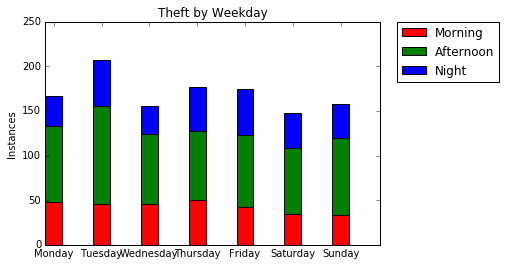

In [13]:
bars("Theft", categories["Theft"]["crimes"], "weekday")

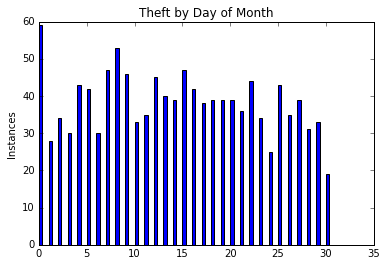

In [14]:
bars("Theft", categories["Theft"]["crimes"], "monthday")

### Observation
The 15th and 1st of each month have the most theft.

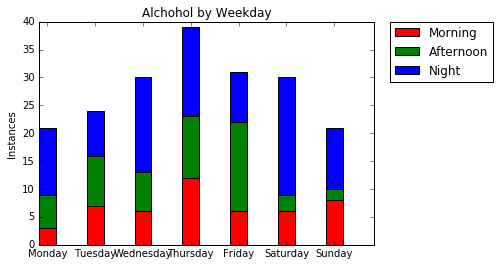

In [15]:
bars("Alchohol", categories["Quality of Life"]["children"]["Drugs"]["crimes"], "weekday")

### Observation
People are most irresponsible with Alchohol on Thursdays.

### Bias Observation:
Notice that in theft by weekday and alcohol by weekday, the most eventful days were Tuesday and Thursday respectfully. A possible observation about this: perhaps these weren't actually the most eventful days, but just the days where the police had the most time to input the data. Maybe Friday and Saturday were more eventful, so much so that the police were less likely to plot data.
So, maybe we have this bias effect normalizing all of our data, making it hard to spot these "crime spikes" in any way that seems reasonable to make conclusions from.